# MiniProject 1 - KNN algorithm
Group 63: Pauline Rivière



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sns

In [2]:
np.random.seed(1234)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/mini_proj1/'

Mounted at /content/drive


# Import data

### Breast cancer data


In [4]:
train_data = np.genfromtxt(path+"train_data_Cancer_cleanRow.csv", delimiter=",")
test_data = np.genfromtxt(path+"test_data_Cancer_cleanRow.csv", delimiter=",")
train_labels = np.genfromtxt(path+"train_labels_Cancer_cleanRow.csv", delimiter=",", dtype = 'int')
test_labels = np.genfromtxt(path+"test_labels_Cancer_cleanRow.csv", delimiter=",", dtype = 'int')


In [5]:
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)

data = np.concatenate((train_data, test_data), axis=0)
print(data.shape)

(512, 9) (171, 9) (512,) (171,)
(683, 9)


### Hepatitis data

In [6]:
train_data_hep = np.genfromtxt(path+"train_data_hep_cleanRow.csv", delimiter=",")
test_data_hep = np.genfromtxt(path+"test_data_hep_cleanRow.csv", delimiter=",")
train_labels_hep = np.genfromtxt(path+"train_labels_hep_cleanRow.csv", delimiter=",", dtype = 'int')
test_labels_hep = np.genfromtxt(path+"test_labels_hep_cleanRow.csv", delimiter=",", dtype = 'int')

print(train_data_hep.shape, test_data_hep.shape, train_labels_hep.shape, test_labels_hep.shape)

data_hep = np.concatenate((train_data_hep, test_data_hep), axis=0)
print(data_hep.shape)

(60, 19) (20, 19) (60,) (20,)
(80, 19)


# Task 2: Implement the models


### K-Nearest neighbour model

Initializing the KNN class.

In [7]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
hamming = lambda x1, x2: np.count_nonzero(x1 != x2, axis=-1)
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn_euc = euclidean, dist_fn_cat = hamming, dist_fn_man = manhattan):
        self.dist_fn_euc = dist_fn_euc
        self.dist_fn_cat = dist_fn_cat
        self.dist_fn_man = dist_fn_man
        self.K = K
        return
    
    def fit(self, x, y, cat_present=False, cat_indices=None, cont_indices=None):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        if cat_present == True:
            self.cat = x[:,cat_indices]
            self.cont = x[:,cont_indices]
        self.y = y
        self.C = int(np.max(y) + 1)
        return self
    
    def predict(self, x_test, cat_present=False, cat_indices=None, cont_indices=None, dist_man=False):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        if cat_present == True:
            # slice test data for continuous and categorical features
            test_cat = x_test[:,cat_indices]
            test_cont = x_test[:,cont_indices]
            # use hamming distance for categorical features and euclidean for continuous features
            cat_distances = self.dist_fn_cat(self.cat[None,:,:], test_cat[:,None,:])
            cont_distances = self.dist_fn_euc(self.cont[None,:,:], test_cont[:,None,:])
            # compute the normalized sum of the two distances
            tot_distances = (cat_distances/cat_distances.max()) + (cont_distances/cont_distances.max())
        else:
            if dist_man == True:
              distances = self.dist_fn_man(self.x[None,:,:], x_test[:,None,:])
            else:
              distances = self.dist_fn_euc(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            if cat_present == True:
                knns[i,:] = np.argsort(tot_distances[i])[:self.K]
            else:
                knns[i,:] = np.argsort(distances[i])[:self.K]
            y_prob[i,:] = np.bincount(self.y[knns[i,:]].flatten(), minlength=self.C) 
        y_prob /= self.K
        return y_prob, knns 

### Accuracy and performance functions

In [8]:
def evaluate_acc_knn(yprob, yh):
  y_pred = np.argmax(y_prob,axis=-1)
  accuracy = np.count_nonzero(y_pred == yh, axis=-1)/yh.shape[0]
  return accuracy

def misclassification_knn(yprob, yh):
  y_pred = np.argmax(y_prob,axis=-1)
  misclass = np.count_nonzero(y_pred != yh, axis=-1)/yh.shape[0]
  return misclass

def confusion_matrix(yprob, yh):
    y_pred = np.argmax(y_prob,axis=-1)
    n_classes = 2
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y_pred==c1)*(yh==c2))
    return c_matrix

# Task 3: Run experiments

## Breast cancer dataset

### KNN model

In [9]:
model = KNN(K=3)

y_prob, knns = model.fit(train_data, train_labels).predict(test_data)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

accuracy = evaluate_acc_knn(y_prob, test_labels)
print(test_labels.shape[0])
print(f'accuracy is {accuracy*100:.1f}.')



knns shape: (171, 3)
y_prob shape: (171, 2)
171
accuracy is 97.1.


### Confusion matrix

In [10]:
cmat_breast = confusion_matrix(y_prob, test_labels)
print(cmat_breast)
print(f'accuracy: {np.sum(np.diag(cmat_breast))/np.sum(cmat_breast)*100:.1f}.')

[[113.   0.]
 [  5.  53.]]
accuracy: 97.1.


### Different values for k

The k corresponding to the lower test error is 3 with a misclassification rate of 2.9.
The k corresponding to the lower train error is 1.


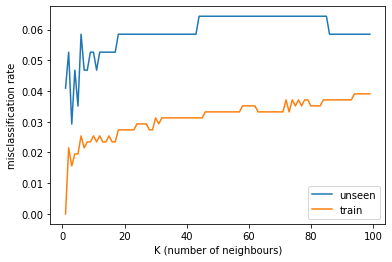

In [11]:
K_list = range(1,100)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data, train_labels).predict(train_data)
    misclass_train = misclassification_knn(y_prob, train_labels)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data, train_labels).predict(test_data)
    misclass_test = misclassification_knn(y_prob, test_labels)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.savefig(path+'k_train_test_breast.png')
plt.show()



### Using Manhattan distance

The k corresponding to the lower test error is 1 with a misclassification rate of 3.5.
The k corresponding to the lower train error is 1.


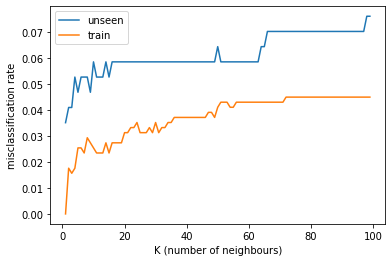

In [12]:
K_list = range(1,100)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data, train_labels).predict(train_data,dist_man=True)
    misclass_train = misclassification_knn(y_prob, train_labels)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data, train_labels).predict(test_data,dist_man=True)
    misclass_test = misclassification_knn(y_prob, test_labels)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.show()

### With replacing of missing data

In [13]:
train_data_rep = np.genfromtxt(path+"train_data_cleanedCancer.csv", delimiter=",")
test_data_rep = np.genfromtxt(path+"test_data_cleanedCancer.csv", delimiter=",")
train_labels_rep = np.genfromtxt(path+"train_labels_cleanedCancer.csv", delimiter=",", dtype = 'int')
test_labels_rep = np.genfromtxt(path+"test_labels_cleanedCancer.csv", delimiter=",", dtype = 'int')

print(train_data_rep.shape, test_data_rep.shape, train_labels_rep.shape, test_labels_rep.shape)

(524, 8) (175, 8) (524,) (175,)


The k corresponding to the lower test error is 8 with a misclassification rate of 4.0.
The k corresponding to the lower train error is 1.


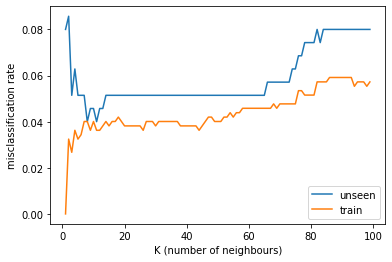

In [14]:
K_list = range(1,100)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_rep, train_labels_rep).predict(train_data_rep)
    misclass_train = misclassification_knn(y_prob, train_labels_rep)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_rep, train_labels_rep).predict(test_data_rep)
    misclass_test = misclassification_knn(y_prob, test_labels_rep)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.show()

## Hepatitis dataset

### KNN model


In [15]:
model = KNN(K=3)

cat_ind_hep = list(range(1,13))
cat_ind_hep.append(18)

cont_ind_hep = [0]
cont_ind_hep.extend(list(range(13,18)))

y_prob, knns = model.fit(train_data_hep, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep).predict(test_data_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

accuracy = evaluate_acc_knn(y_prob, test_labels_hep)
print(f'accuracy is {accuracy*100:.1f}.')

knns shape: (20, 3)
y_prob shape: (20, 2)
accuracy is 85.0.


### Confusion matrix

In [16]:
cmat_hep = confusion_matrix(y_prob, test_labels_hep)
print(cmat_hep)
print(f'accuracy: {np.sum(np.diag(cmat_hep))/np.sum(cmat_hep)*100:.1f}.')

[[ 5.  2.]
 [ 1. 12.]]
accuracy: 85.0.


### Different values for k

The k corresponding to the lower test error is 3 with a misclassification rate of 15.0.
The k corresponding to the lower train error is 1.


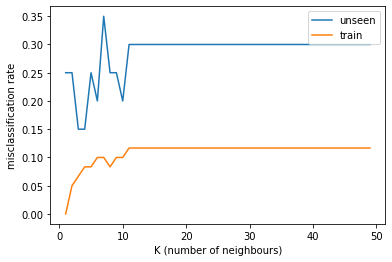

In [17]:
K_list = range(1,50)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep).predict(train_data_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep)
    misclass_train = misclassification_knn(y_prob, train_labels_hep)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep).predict(test_data_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep)
    misclass_test = misclassification_knn(y_prob, test_labels_hep)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.savefig(path+'k_train_test_hep.png')
plt.show()

### With replacing of missing data

In [18]:
train_data_hep_rep = np.genfromtxt(path+"train_data_cleanedHepatitis.csv", delimiter=",")
test_data_hep_rep = np.genfromtxt(path+"test_data_cleanedHepatitis.csv", delimiter=",")
train_labels_hep_rep = np.genfromtxt(path+"train_labels_cleanedHepatitis.csv", delimiter=",", dtype = 'int')
test_labels_hep_rep = np.genfromtxt(path+"test_labels_cleanedHepatitis.csv", delimiter=",", dtype = 'int')
print(train_data_hep_rep.shape, test_data_hep_rep.shape, train_labels_hep_rep.shape, test_labels_hep_rep.shape)

(116, 19) (39, 19) (116,) (39,)


In [19]:
model = KNN(K=3)

cat_ind_hep = list(range(1,13))
cat_ind_hep.append(18)

cont_ind_hep = [0]
cont_ind_hep.extend(list(range(13,18)))

y_prob, knns = model.fit(train_data_hep_rep, train_labels_hep_rep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep).predict(test_data_hep_rep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

accuracy = evaluate_acc_knn(y_prob, test_labels_hep_rep)

print(f'accuracy is {accuracy*100:.1f}.')

knns shape: (39, 3)
y_prob shape: (39, 2)
accuracy is 74.4.


## Feature scaling and selection

### Feature scaling for hepatitis dataset

In [20]:
min_max_scaler = preprocessing.MinMaxScaler()
train_data_hep_minmax = min_max_scaler.fit_transform(train_data_hep)

test_data_hep_minmax = min_max_scaler.transform(test_data_hep)

In [21]:
model = KNN(K=3)

cat_ind_hep = list(range(1,13))
cat_ind_hep.append(18)

cont_ind_hep = [0]
cont_ind_hep.extend(list(range(13,18)))

y_prob, knns = model.fit(train_data_hep_minmax, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep).predict(test_data_hep_minmax, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

accuracy = evaluate_acc_knn(y_prob, test_labels_hep)
print(f'accuracy is {accuracy*100:.1f}.')

knns shape: (20, 3)
y_prob shape: (20, 2)
accuracy is 80.0.


Using Euclidean distance

The k corresponding to the lower test error is 4 with a misclassification rate of 15.0.
The k corresponding to the lower train error is 1.


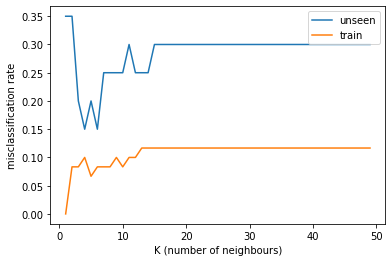

In [22]:
K_list = range(1,50)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_minmax, train_labels_hep).predict(train_data_hep_minmax)
    misclass_train = misclassification_knn(y_prob, train_labels_hep)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_minmax, train_labels_hep).predict(test_data_hep_minmax)
    misclass_test = misclassification_knn(y_prob, test_labels_hep)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.show()

Using Manhattan distance

The k corresponding to the lower test error is 4 with a misclassification rate of 15.0.
The k corresponding to the lower train error is 1.


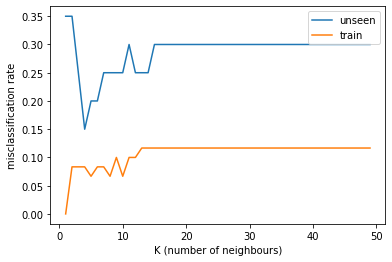

In [23]:
K_list = range(1,50)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_minmax, train_labels_hep).predict(train_data_hep_minmax, dist_man = True)
    misclass_train = misclassification_knn(y_prob, train_labels_hep)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_minmax, train_labels_hep).predict(test_data_hep_minmax, dist_man = True)
    misclass_test = misclassification_knn(y_prob, test_labels_hep)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.show()

For hepatitis dataset, albumin seems an important feature but the scale is small. We rescale it by 100 to increase its weight.

In [24]:
scale = 100
train_data_hep_alb100 = np.copy(train_data_hep)
test_data_hep_alb100 = np.copy(test_data_hep)
train_data_hep_alb100[:, 16] = np.dot(train_data_hep[:,16], scale)
test_data_hep_alb100[:, 16] = np.dot(test_data_hep[:,16], scale)

The k corresponding to the lower test error is 3 with a misclassification rate of 15.0.
The k corresponding to the lower train error is 1.


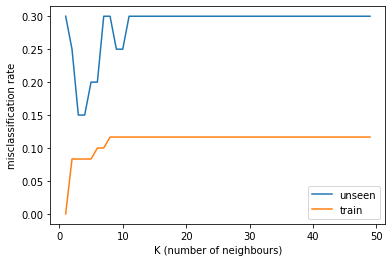

In [25]:
K_list = range(1,50)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_alb100, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep).predict(train_data_hep_alb100, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep)
    misclass_train = misclassification_knn(y_prob, train_labels_hep)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_alb100, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep).predict(test_data_hep_alb100, cat_present=True, cat_indices = cat_ind_hep, cont_indices= cont_ind_hep)
    misclass_test = misclassification_knn(y_prob, test_labels_hep)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.savefig(path+'k_train_test_hep.png')
plt.show()

### Feature selection

Looking at the correlation of the features with the labels.

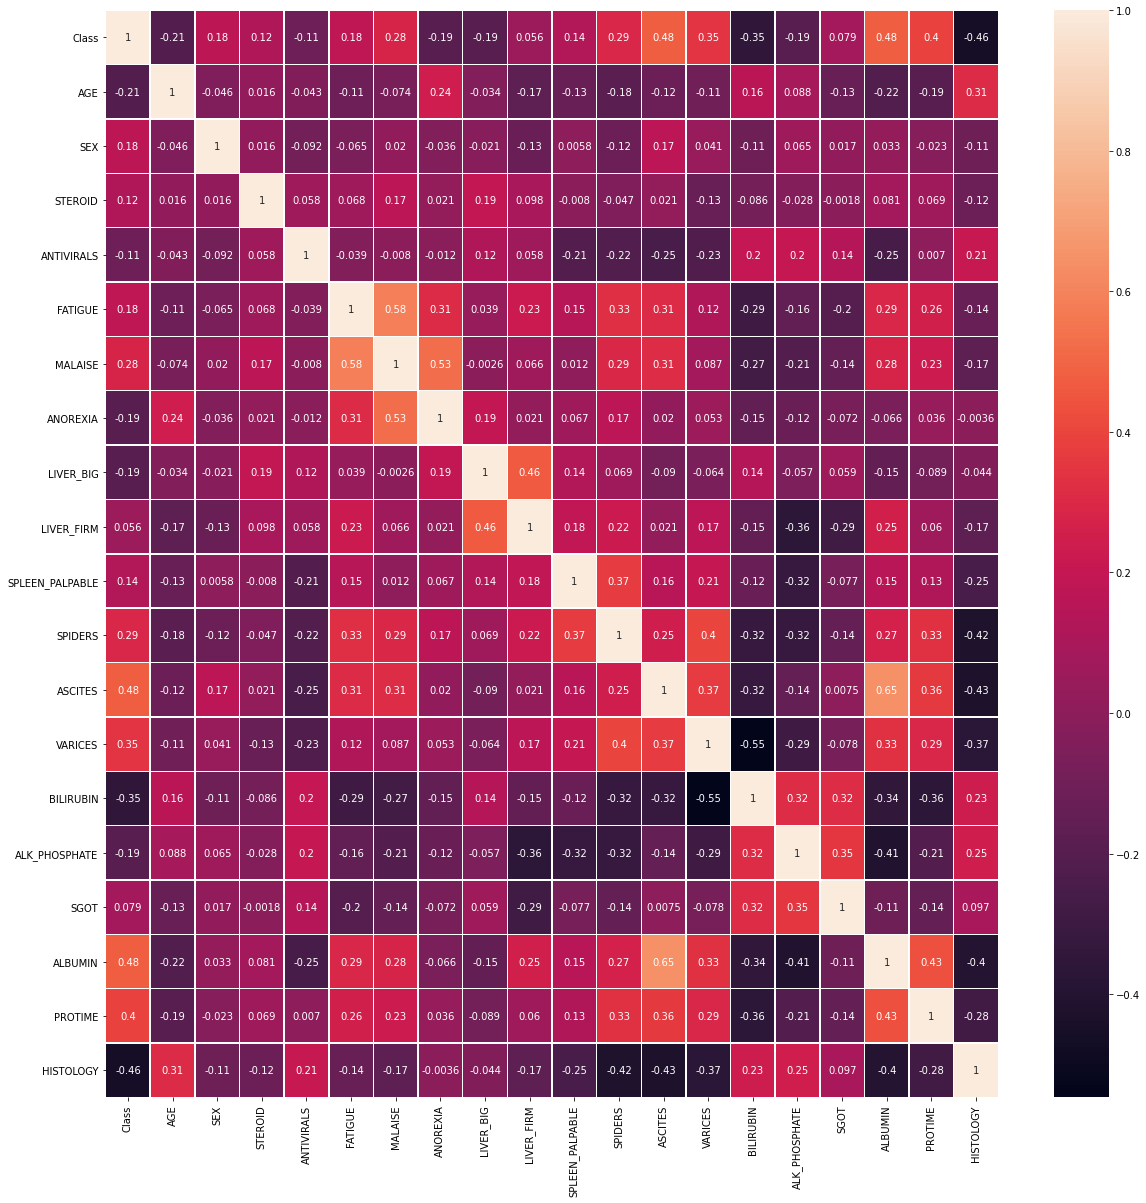

In [26]:
df_hep = pd.read_csv(path+"Cleaned_hep_Row.csv", names = ['Class', 'AGE', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE', 'MALAISE', 'ANOREXIA', 'LIVER_BIG', 'LIVER_FIRM', 'SPLEEN_PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES', 'BILIRUBIN', 'ALK_PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME', 'HISTOLOGY', 'Na'])
df_hep = df_hep.drop('Na', axis=1)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df_hep.corr(), annot = True, linewidths=.5, ax=ax)
plt.savefig(path+'corr_hep.png')

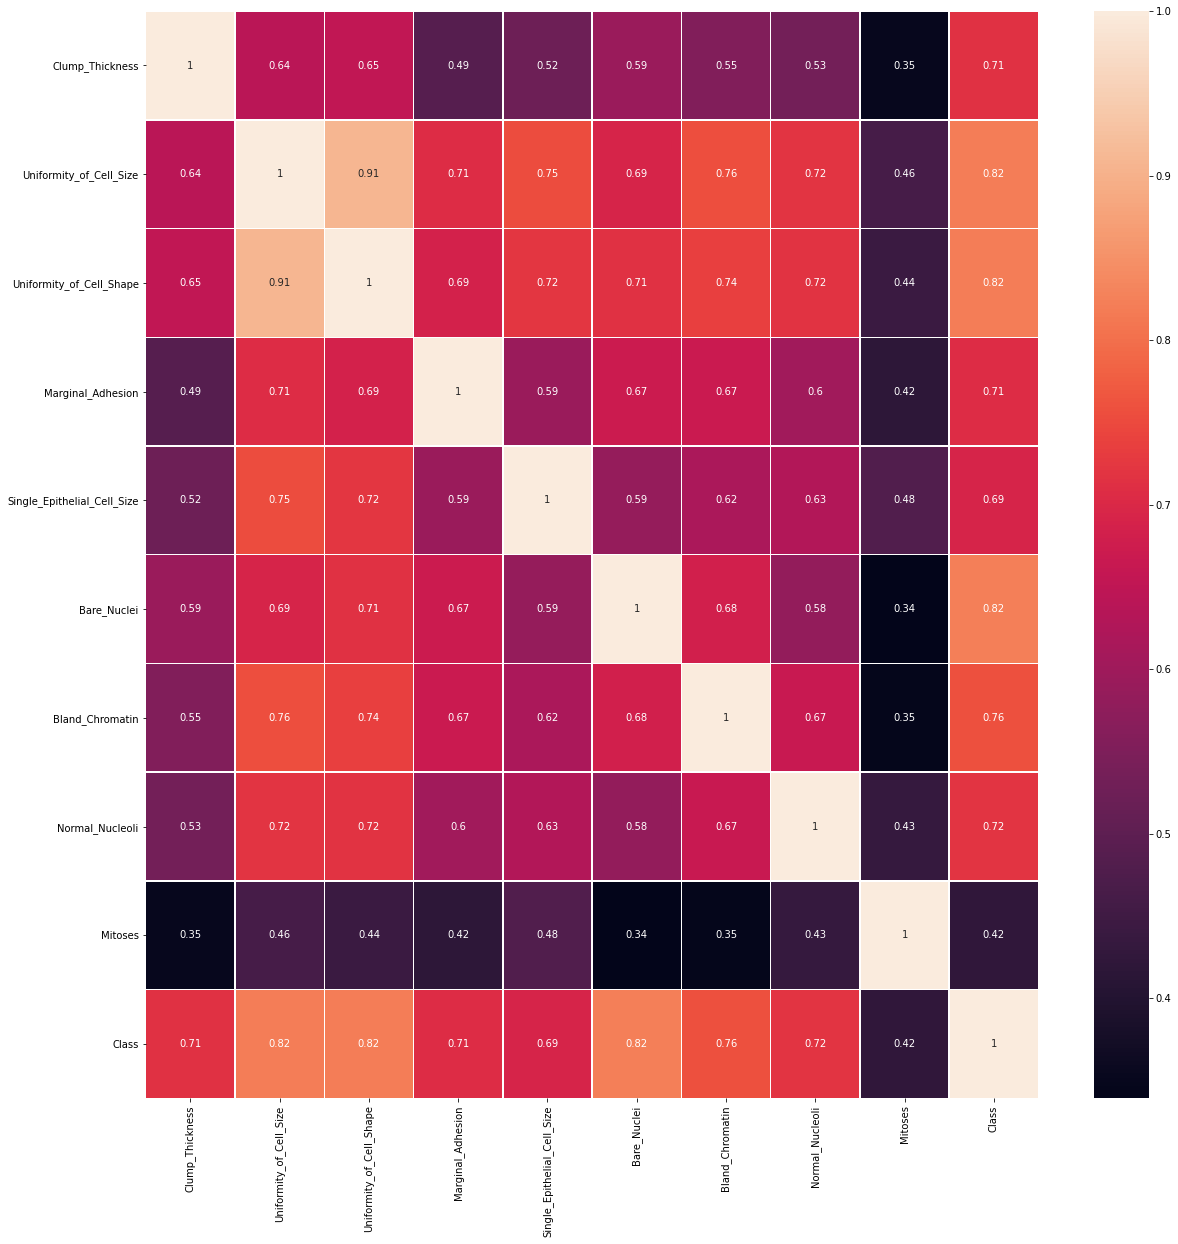

In [27]:
df = pd.read_csv(path+"Cleaned_Cancer_Row.csv", index_col=False, names = ['id','Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class'])
df = df.drop('id', axis=1)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), annot = True, linewidths=.5, ax=ax)
plt.savefig(path+'corr_breast.png')

Breast cancer dataset: we try to remove the mitoses feature that has the lowest correlation with class labels.

In [28]:
print(train_data.shape, test_data.shape)
train_data_f8 = np.delete(train_data, 8, 1)
test_data_f8 = np.delete(test_data, 8, 1)
print(train_data_f8.shape, test_data_f8.shape)

(512, 9) (171, 9)
(512, 8) (171, 8)


The k corresponding to the lower test error is 3 with a misclassification rate of 2.9.
The k corresponding to the lower train error is 1.


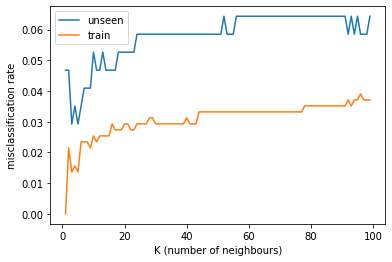

In [29]:
K_list = range(1,100)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_f8, train_labels).predict(train_data_f8)
    misclass_train = misclassification_knn(y_prob, train_labels)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_f8, train_labels).predict(test_data_f8)
    misclass_test = misclassification_knn(y_prob, test_labels)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.savefig(path+'k_train_test_breast.png')
plt.show()

Hepatitis dataset: we try to remove the SGOT and liver firm features that are the least correlated with class labels.

In [30]:
print(train_data_hep.shape, test_data_hep.shape)
train_data_hep_f17 = np.delete(train_data_hep, [8,15], 1)
test_data_hep_f17 = np.delete(test_data_hep, [8,15], 1)
print(train_data_hep_f17.shape, test_data_hep_f17.shape)

(60, 19) (20, 19)
(60, 17) (20, 17)


The k corresponding to the lower test error is 3 with a misclassification rate of 15.0.
The k corresponding to the lower train error is 1.


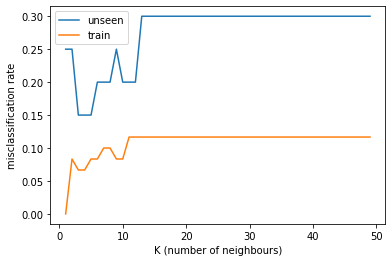

In [31]:
cat_ind_hep_f17 = list(range(1,12))
cat_ind_hep_f17.append(16)

cont_ind_hep_f17 = [0]
cont_ind_hep_f17.extend(list(range(12,16)))

K_list = range(1,50)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_f17, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep_f17, cont_indices= cont_ind_hep_f17).predict(train_data_hep_f17, cat_present=True, cat_indices = cat_ind_hep_f17, cont_indices= cont_ind_hep_f17)
    misclass_train = misclassification_knn(y_prob, train_labels_hep)
    err_train.append(misclass_train)

for i, K in enumerate(K_list):
    model = KNN(K=K)
    y_prob, knns = model.fit(train_data_hep_f17, train_labels_hep, cat_present=True, cat_indices = cat_ind_hep_f17, cont_indices= cont_ind_hep_f17).predict(test_data_hep_f17, cat_present=True, cat_indices = cat_ind_hep_f17, cont_indices= cont_ind_hep_f17)
    misclass_test = misclassification_knn(y_prob, test_labels_hep)
    err_test.append(misclass_test)

best_value_test = min(err_test)
best_k_test = err_test.index(best_value_test)
print(f'The k corresponding to the lower test error is {best_k_test+1} with a misclassification rate of {best_value_test*100:.1f}.')

best_value_train = min(err_train)
best_k_train = err_train.index(best_value_train)
print(f'The k corresponding to the lower train error is {best_k_train+1}.')

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('misclassification rate')
plt.show()

# Report performance of best model

## Decision boundary plot

### Breast cancer dataset

Based on the correlation analysis, the uniformity of cell size and shape features are the most correlated with class.

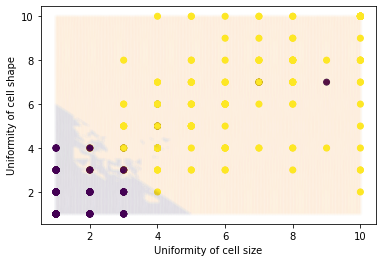

In [32]:
train_data_red = train_data[:,1:3]

#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(data[:,1]), np.max(data[:,1]), 200)
x1v = np.linspace(np.min(data[:,2]), np.max(data[:,2]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN(K=3)

#to get class probability of all the points in the 2D grid
y_prob_all, _ = model.fit(train_data_red, train_labels).predict(x_all)

y_pred_all = np.argmax(y_prob_all,axis=-1)

plt.scatter(train_data[:,1], train_data[:,2],c=train_labels, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1],c=y_pred_all, marker='.', alpha=0.01)
plt.ylabel('Uniformity of cell shape')
plt.xlabel('Uniformity of cell size')
plt.savefig(path+'knn_boundary_breast.png')
plt.show()

### Hepatitis dataset

Based on the correlation analysis, albumin and bilirubin are two of the most correlated with class.

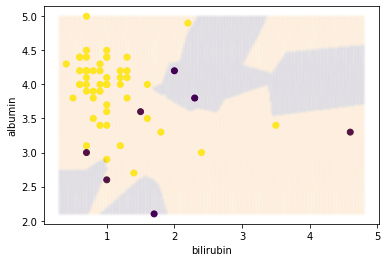

In [33]:
train_data_hep_red = train_data_hep[:,[13,16]]
scale = 100
# train_data_hep_red[:,0] = np.dot(train_data_hep_red[:,0], scale)

data_hep_red = data_hep[:,[13,16]]
# data_hep_red[:,0] = np.dot(data_hep_red[:,0], scale)

#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(data_hep_red[:,0]), np.max(data_hep_red[:,0]), 200)
x1v = np.linspace(np.min(data_hep_red[:,1]), np.max(data_hep_red[:,1]), 200)

#to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = KNN(K=3)

#to get class probability of all the points in the 2D grid
y_prob_all, _ = model.fit(train_data_hep_red, train_labels_hep).predict(x_all)

y_pred_all = np.argmax(y_prob_all,axis=-1)

plt.scatter(train_data_hep_red[:,0], train_data_hep_red[:,1],c=train_labels_hep, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1],c=y_pred_all, marker='.', alpha=0.01)
plt.ylabel('albumin')
plt.xlabel('bilirubin')
plt.savefig(path+'knn_boundary_hepatitis.png')
plt.show()